In [650]:
import torch
import torchvision
import torchvision.transforms as transforms
import skimage.io as skio
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from tqdm import trange

from torchmetrics import PeakSignalNoiseRatio

path = 'lion_orig.png'
img = skio.imread(path)

In [318]:
configs = {
    'lr': .0001,
    'bs': 128,
    'epochs': 2000
}

In [579]:
def inp_mapping(v, B, no=False):
    if no:
        return v
    x_proj = 2 * np.pi * v @ B.T
    return np.concatenate([np.cos(x_proj), np.sin(x_proj)], axis=1)

In [653]:
class MLP(nn.Module):
    def __init__(self, input_n=2, num_layers=3, num_channels=256, enc=lambda x: basic(x)):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers += [nn.Linear(input_n, num_channels), nn.ReLU()]
        for _ in range(num_layers):
            self.layers += [nn.Linear(num_channels, num_channels)]
            self.layers += [nn.ReLU()]
        self.layers += [nn.Linear(num_channels, 3)]
        self.layers += [nn.Sigmoid()]
        self.enc = enc
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def render(model, x_train):
    output = model(torch.tensor(x_train, dtype=torch.float).cuda()).detach().cpu().numpy()
    return output.reshape(img.shape)
    
def train(model, criterion, optimizer, configs, x_train, target_train, x_test, target_test, show_imgs=False):
    psnr_test = []
    psnr_train = []
    pbar = trange(configs['epochs'], desc="Epochs")
    for epoch in pbar:
        inputs = x_train
        optimizer.zero_grad()
        outputs = model(inputs)
        recon = outputs.reshape(target_train.shape)
        loss = criterion(recon, target_train)
        loss.backward()
        optimizer.step()
        psnr_train += [psnr(torch.tensor(recon.detach().cpu().numpy()), torch.tensor(target_train.detach().cpu().numpy())).item()]
        # test
        with torch.no_grad():
            inputs = x_test
            outputs = model(inputs)
            recon, t = model(x_test).reshape(target_test.shape).detach().cpu().numpy(), target_test.detach().cpu().numpy()
            psnr_val = psnr(torch.tensor(recon), torch.tensor(t))
            psnr_test += [psnr_val.item()]
            if show_imgs:
                fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
                ax1.imshow(t)
                ax1.axis('off')
                ax2.imshow(recon)
                ax2.axis('off')
                plt.savefig("out/recon_" + str(epoch) + ".png", bbox_inches='tight')
#                 plt.show()
                plt.close(fig)
                pbar.set_description(f"PSNR: {psnr_val}")
    return psnr_train, psnr_test

def display_psnr(psnr_train, psnr_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
    ax1.plot(range(len(psnr_train)), psnr_train)
    ax2.plot(range(len(psnr_test)), psnr_test)

def display_psnr_test(psnr_test, sigma):
    i = 0
    for t in psnr_test:
        plt.plot(range(len(t)), t, label=sigma[i])
        i+=1
    plt.legend()

In [654]:
psnr = PeakSignalNoiseRatio()
coords = np.linspace(0, img.shape[0], img.shape[0], endpoint=False)
B = np.random.normal(0, 15, size=(256, 2))
no = False
show_imgs = True

x_test = np.stack(np.meshgrid(coords, coords), -1)[1::2, 1::2, :]
x_test = inp_mapping(x_test.reshape(x_test.shape[0] ** 2, 2)/(2*x_test.shape[0]), B, no=no)
x_test = torch.tensor(x_test, dtype=torch.float)
x_test = x_test.cuda()
target_test = torch.tensor(img[1::2, 1::2, :]/255., dtype=torch.float).cuda()

x_train = np.stack(np.meshgrid(coords, coords), -1)[::2, ::2, :]
x_train = inp_mapping(x_train.reshape(x_train.shape[0] ** 2, 2)/(2*x_train.shape[0]), B, no=no)
x_train = torch.tensor(x_train, dtype=torch.float)
x_train = x_train.cuda()
target_train = torch.tensor(img[::2, ::2, :]/255., dtype=torch.float).cuda()

model = MLP(input_n=len(x_train[0]), enc=basic, num_layers=10, num_channels=1024).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'])
_, psnr_test = train(model, criterion, optimizer, configs, x_train, target_train, x_test, target_test, show_imgs=show_imgs)

PSNR: 24.10612678527832:  22%|███████████▊                                          | 438/2000 [06:09<21:58,  1.18it/s]


KeyboardInterrupt: 

In [627]:
psnr_tests = []
sigmas = np.arange(.1, 5, .1)
for sigma in sigmas:
    psnr = PeakSignalNoiseRatio()
    coords = np.linspace(0, img.shape[0], img.shape[0], endpoint=False)
    B = np.random.normal(0, sigma, size=(256, 2))
    no = False
    show_imgs = False

    x_test = np.stack(np.meshgrid(coords, coords), -1)[1::2, 1::2, :]
    x_test = inp_mapping(x_test.reshape(x_test.shape[0] ** 2, 2)/(2*x_test.shape[0]), B, no=no)
    x_test = torch.tensor(x_test, dtype=torch.float)
    x_test = x_test.cuda()
    target_test = torch.tensor(img[1::2, 1::2, :]/255., dtype=torch.float).cuda()

    x_train = np.stack(np.meshgrid(coords, coords), -1)[::2, ::2, :]
    x_train = inp_mapping(x_train.reshape(x_train.shape[0] ** 2, 2)/(2*x_train.shape[0]), B, no=no)
    x_train = torch.tensor(x_train, dtype=torch.float)
    x_train = x_train.cuda()
    target_train = torch.tensor(img[::2, ::2, :]/255., dtype=torch.float).cuda()

    model = MLP(input_n=len(x_train[0]), enc=basic).cuda()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'])
    _, psnr_test = train(model, criterion, optimizer, configs, x_train, target_train, x_test, target_test, show_imgs=show_imgs)
    psnr_tests += [psnr_test]

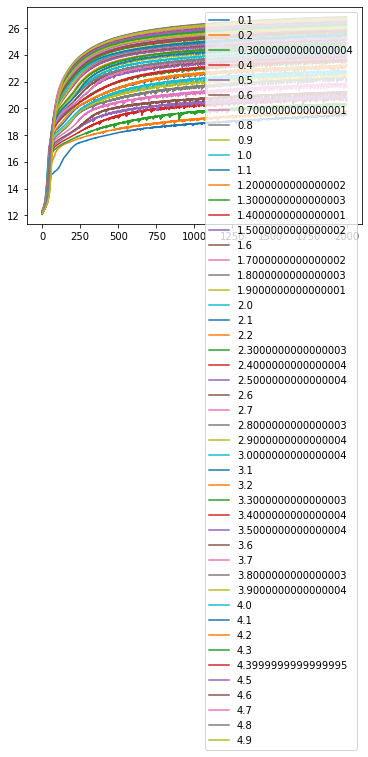

In [628]:
display_psnr_test(psnr_tests, sigmas)

In [645]:
import imageio
from glob import glob
images = []
filenames = sorted(glob("out/*.png"), key=lambda x: int(x.split('.')[0].split('_')[-1]))
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)